In [3]:
from tqdm.notebook import tqdm
import pickle, gzip

import numpy as np
import pandas as pd
import torch

import nibabel as nib
from nilearn import maskers
from nilearn.image import resample_img

from neurovlm.data import get_data_dir
from neurovlm.models import Specter
from neurovlm.visualize_network_predictions import (
plot_single_category,create_predictions_from_search_results

)

from neurovlm.brain_input import (
    search_papers_from_brain,
    search_wiki_from_brain,
    resample_networks_to_mask,
    search_cogatlas_from_brain
)

from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_networks, _load_masker )

## Load models and data

In [2]:
autoencoder = _load_autoencoder()

In [3]:
networks = _load_networks()
masker = _load_masker()

## Resample and embed networks

In [4]:
# Resample Network
networks_resampled = resample_networks_to_mask(networks)

Resampling networks: 100%|██████████| 152/152 [00:03<00:00, 47.36it/s] 


In [5]:
networks_embed = {}

with torch.no_grad():
    for k, v in tqdm(networks_resampled.items(), total=len(networks_resampled)):
        networks_embed[k] = autoencoder.encoder(torch.from_numpy(masker.transform(v)))

  0%|          | 0/152 [00:00<?, ?it/s]

In [18]:
# Network labels
networks_embed.keys()

dict_keys(['VIS-P', 'CG-OP', 'DN-B', 'SMOT-B', 'AUD', 'PM-PPr', 'dATN-B', 'SMOT-A', 'LANG', 'FPN-B', 'FPN-A', 'dATN-A', 'VIS-C', 'SAL/PMN', 'DN-A', 'NONE', 'Visual1', 'Visual2', 'Somatomotor', 'CingOperc', 'DorsAttn', 'Language', 'FrontPar', 'Auditory', 'Default', 'PostMulti', 'VentMulti', 'OrbitAffective', 'ICA1', 'ICA2', 'ICA3', 'ICA4', 'ICA5', 'ICA6', 'ICA7', 'ICA8', 'ICA9', 'ICA10', 'ICA11', 'ICA12', 'ICA13', 'ICA14', 'ICA15', 'ICA17', 'ICA18', 'ICA19', 'ICA20', 'ICA23', 'Emo/Interoception1', 'Emo/Interoception2', 'Emo/Interoception3', 'Emo/Interoception4', 'Mot/Visspatial1', 'Mot/Visspatial2', 'Mot/Visspatial3', 'Mot/Visspatial4', 'Visual3', 'DivergentCog1', 'DivergentCog3', 'DivergentCog4', 'DivergentCog5', 'DivergentCog6', 'medial frontal', 'frontoparietal', 'default mode', 'motor cortex', 'visual A', 'visual B', 'visual association', 'subcortical cerebellum', 'AntSal', 'DorsalDMN', 'HighVisual', 'LECN', 'PostSal', 'Precuneus', 'PrimVisual', 'RECN', 'Sensorimotor', 'VentralDMN',

## Brain to text (Network vs Paper)

In [19]:
# Find the top 5 most similar papers for a particular network
abstract, titles, cos_sim = search_papers_from_brain(networks_embed["AUD"], show_titles=True)

Top matches:
1. The retention of simultaneous tones in auditory short-term memory: A magnetoencephalography study
2. Spectral and temporal processing in human auditory cortex.
3. Auditory perception of natural sound categories – An fMRI study
4. Representation of the temporal envelope of sounds in the human brain.
5. From Vivaldi to Beatles and back: Predicting lateralized brain responses to music


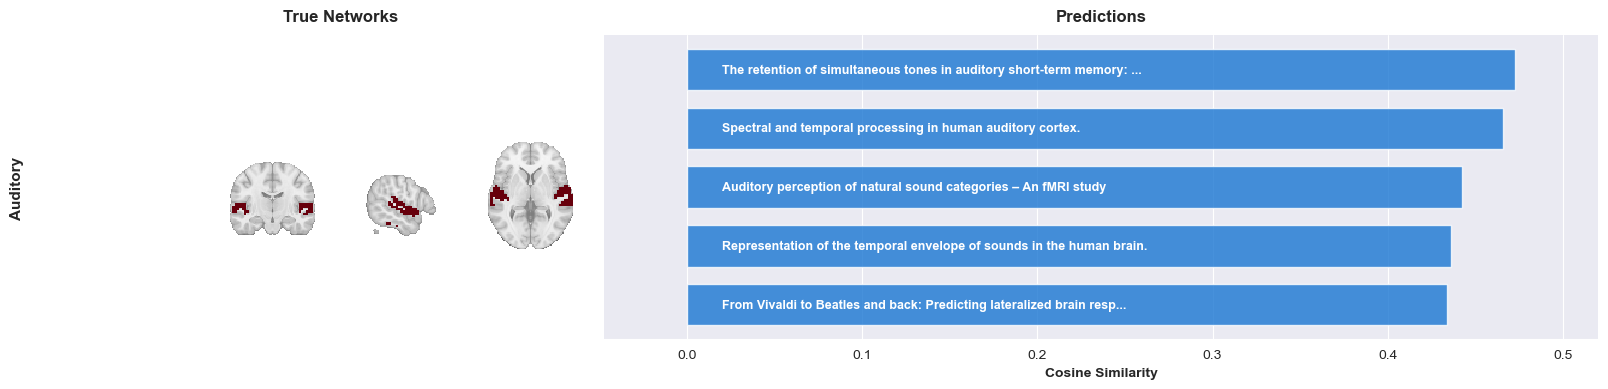

In [20]:
paper_predictions = list(zip(titles, cos_sim))

pred_dict = {
    "network_name": "Auditory",
    "brain_image": networks_resampled["AUD"],  # ← Fixed
    "predictions": paper_predictions,
}
pred_lst = [pred_dict]

fig = plot_single_category(pred_lst, figsize=(16, 4))

## Network v wiki

In [21]:
# Find the top 5 most similar NeuroWiki terms to a particular network
summary, titles, cos_sim = search_wiki_from_brain(networks_embed["AUD"], top_k= 5 ,show_titles=True)

Top matches:
1. Temporal masking
2. Melodic expectation
3. Search by sound
4. Beat (acoustics)
5. Harmonic series (music)


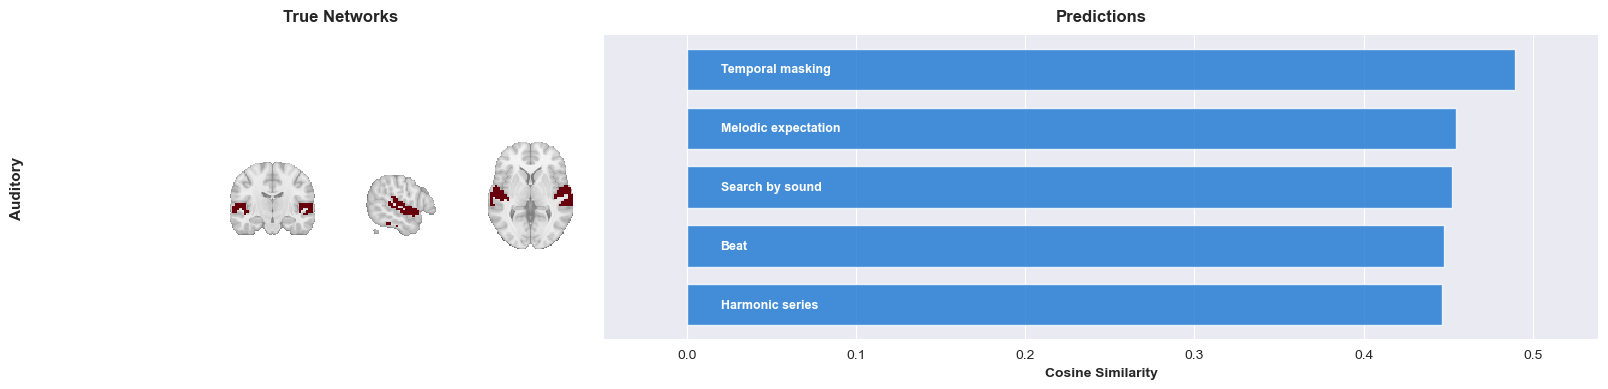

In [22]:
paper_predictions = list(zip(titles, cos_sim))

pred_dict = {
    "network_name": "Auditory",
    "brain_image": networks_resampled["AUD"],  # ← Fixed
    "predictions": paper_predictions,
}
pred_lst = [pred_dict]

fig = plot_single_category(pred_lst, figsize=(16, 4))

## Network V. Cognitive Atlas (concepts, task, diseases)

In [23]:
definition, terms, similarity_scores = search_cogatlas_from_brain(networks_embed["AUD"], top_k=5, show_titles=True)

Top matches:
1. auditory stream segregation
2. auditory encoding
3. music cognition
4. acoustic phonetic processing
5. auditory tone detection


In [24]:
definition2, terms2, similarity_scores2 = search_cogatlas_from_brain(networks_embed["visual A"], top_k=5, show_titles=True)


Top matches:
1. visual memory
2. visual object detection
3. object perception
4. visual orientation
5. visual object recognition


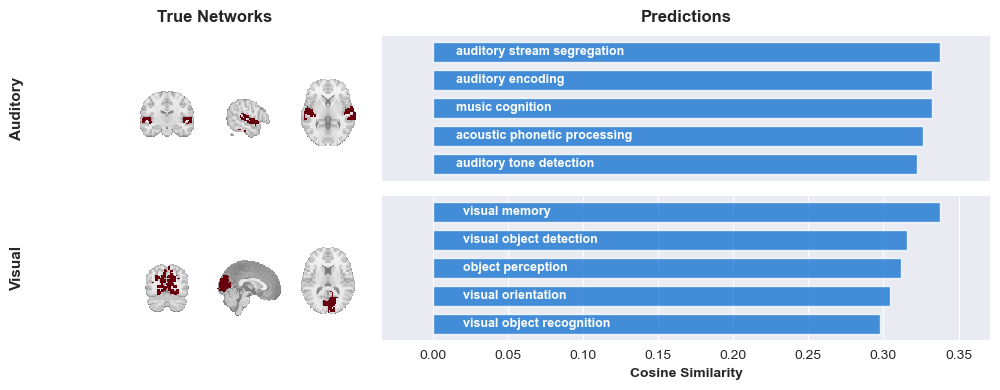

In [25]:
paper_predictions = list(zip(terms, similarity_scores))
paper_predictions2 = list(zip(terms2, similarity_scores2))

pred_dict = {
    "network_name": "Auditory",
    "brain_image": networks_resampled["AUD"],
    "predictions": paper_predictions,
}
pred_dict2 = {
    "network_name": "Visual",
    "brain_image": networks_resampled["visual A"],
    "predictions": paper_predictions2,
}
pred_lst = [pred_dict, pred_dict2]

fig = plot_single_category(pred_lst)

In [26]:
# Disorders
definition, terms, similarity_scores = search_cogatlas_from_brain(networks_embed["Somatomotor"], top_k=5, show_titles=True, category = "cogatlas_disorder")

Top matches:
1. philoprogeria
2. tetraplegia
3. ideomotor apraxia
4. stereotypic movement disorder
5. developmental coordination disorder


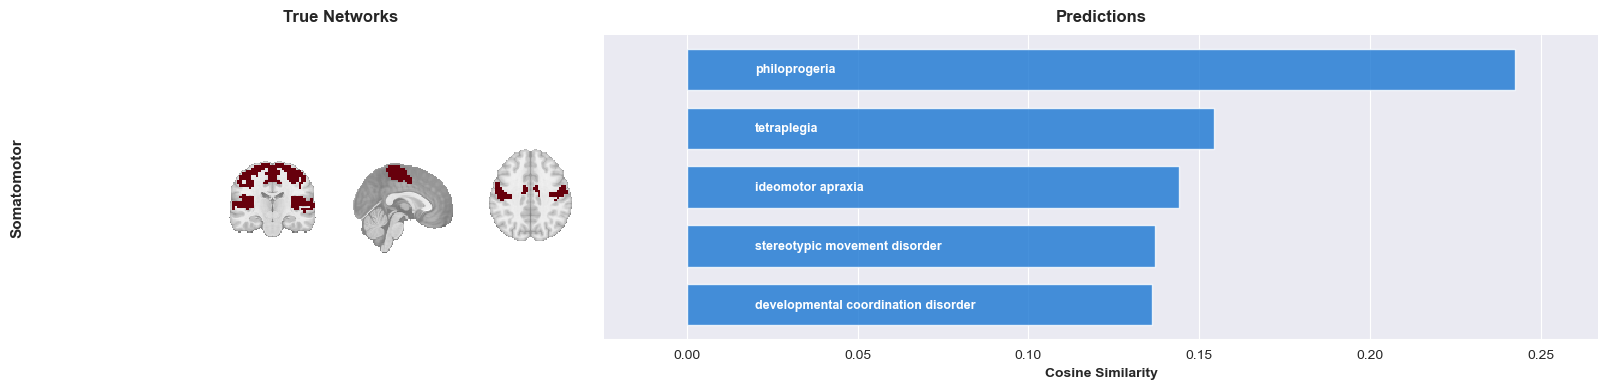

In [27]:
paper_predictions = list(zip(terms, similarity_scores))

pred_dict = {
    "network_name": "Somatomotor",
    "brain_image": networks_resampled["Somatomotor"],
    "predictions": paper_predictions,
}
pred_lst = [pred_dict]

fig = plot_single_category(pred_lst, figsize=(16, 4))

In [28]:
# Tasks
definition, terms, similarity_scores = search_cogatlas_from_brain(networks_embed["Somatomotor"], top_k=5, show_titles=True, category = "cogatlas_task")

Top matches:
1. vibrotactile monitor/discrimination
2. flexion/extension
3. phasic pain stimulation
4. music comprehension/production
5. mechanical stimulation


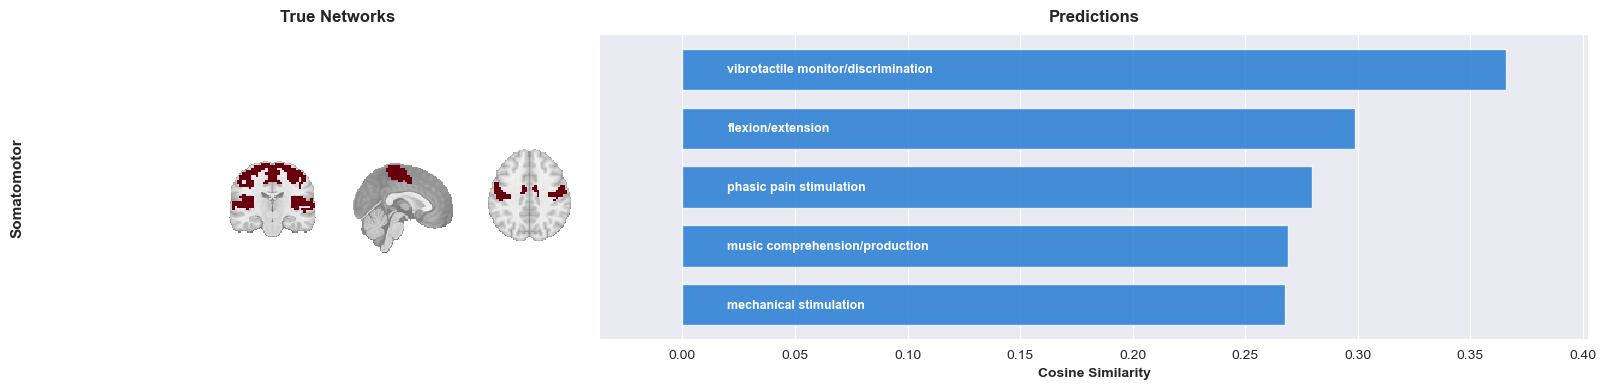

In [29]:
paper_predictions = list(zip(terms, similarity_scores))

pred_dict = {
    "network_name": "Somatomotor",
    "brain_image": networks_resampled["Somatomotor"],
    "predictions": paper_predictions,
}
pred_lst = [pred_dict]

fig = plot_single_category(pred_lst, figsize=(16, 4))